This script compares the added value of using additional GMT charactersitics as an indicator when talking about future climate impacts. We do this by introducing metrics that describe certain aspects of the GMT charactersitics and comparing how a base model that only relies on GMT at the end-of-century imrpoves when having additional information


In [3]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )


### Settings

In [4]:
thrshld = 1.35
thrshld_str = '135'

### Step 1: Load and Prepare Data 

a. GDP Data

In [ ]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']].loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Refp5', 'scen'] = 'Ref1p5'
gdp_df['run'] = [f.split('_')[-1] for f in gdp_df['run']]
gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
gdp_df.reset_index(drop = True, inplace = True)
gdp_df['diff_SSP2'] = gdp_df['SSP2_clim']/gdp_df['SSP2']
# only keep data for year that we are interested in: 
gdp_baseline = gdp_df[gdp_df.year == 2015]['SSP2'].values
gdp_df  = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with keys in GMT dataset
gdp_isos  = gdp_df.iso.unique()

b. Country-level temperatures

In [6]:
tas_df = pd.read_csv(cset.file_tas)
tas_df = tas_df[(tas_df.year == 2015) & (~tas_df['run'].str.contains('Ref_1p5'))].copy()
tas_df = tas_df.loc[tas_df.iso.isin(gdp_isos),:].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Refv2'), 'scen_run'] = tas_df['scen_run'].str.replace('Refv2', 'Ref')

c. GMT dataset

In [9]:
# loading & preparing glmt data 
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{thrshld_str}.csv', index_col = 0)

d. Combine into a single regression Dataset

In [31]:
# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(gmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
# - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df['tas_soc']      -= regression_df['tas_baseline']
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_os']       = regression_df['gmt_max']- regression_df['gmt_eoc']
regression_df['log_gmt_cum']  = np.log(regression_df['gmt_cum'])
regression_df['gmt_delta_max'] = regression_df['gmt_max'] - regression_df['gmt_eoc']

In [44]:
# store regrion dataset for later use
Path(cset.path_CHAR_results).mkdir(parents=True, exist_ok=True)
regression_df.to_csv(cset.path_CHAR_results / f'regression_data_thsld_{thrshld_str}.csv')

### Step 2: Preprocessing 

a. Define Target regression Variable 
- We tested multiple variables and found the logarithm of GDP/GDP_baseline to be by far the best target variable

In [32]:
y = np.log(regression_df['diff_SSP2'])

b. Generate a predictor dataset
- as we have multiple predictors, we employ StandardScaler to alignt their magnitudes 
- we employed individual country-level regression first and found the regression coefficients to be approximately linear w.r.t. to the country's baseline temperature, therefore, we allow 2nd order interaction terms between a country's baseline temperature (tas_baseline) and the predictor variables. This is equivalent to allowing coefficients of selected predictors to vary linearly with tas_baseline: (a+b*tas_baseline)*predictor

In [33]:
# Define predictor variable space 
predictors = ['tas_soc', 'tas_baseline', 'gmt_cum', 'gmt_max', 'gmt_eoc', 'gmt_exc', 'gmt_ntwr', 'gmt_os']

# Generate second-order terms
poly       = PolynomialFeatures(3, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])

# Scale predictor Dataset
X_poly_std = StandardScaler().fit_transform(X_poly)

# Create a predictor matrix
poly_feature_names  = poly.get_feature_names_out(predictors)
predictor_df        = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index

# interactions with tas_baseline 
interaction_terms   = [f for f in poly_feature_names if (('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2'))]
# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

c. Check relationships between varaibles in predictor dataset

<Figure size 640x480 with 0 Axes>

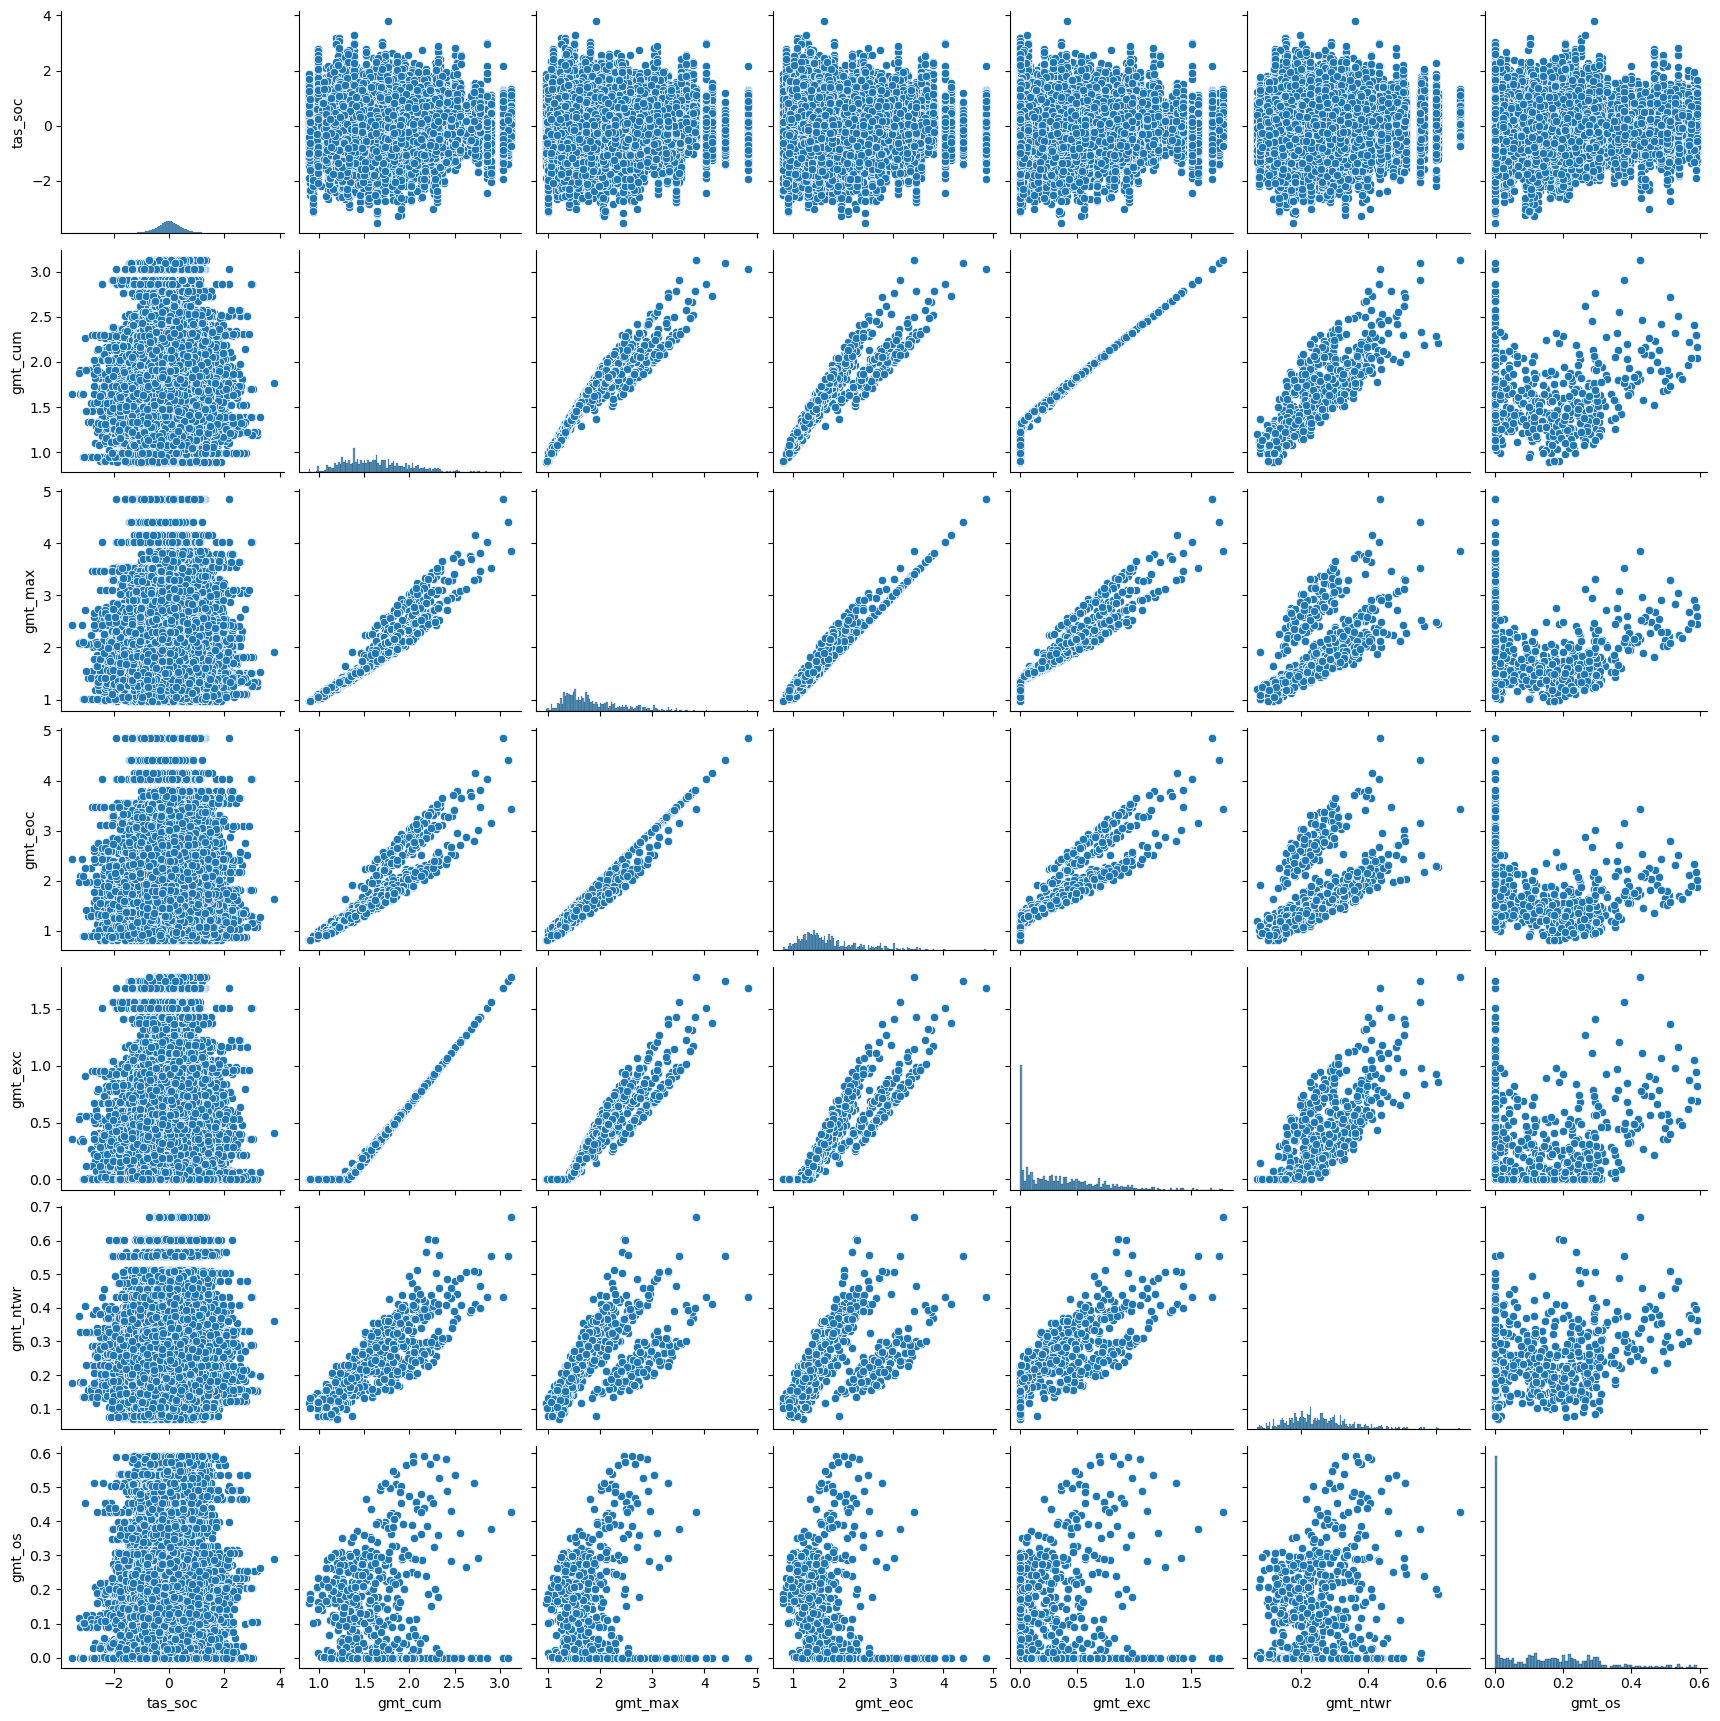

In [34]:
plt.figure()
sns.pairplot(regression_df.loc[:, ['tas_soc', 'gmt_cum', 'gmt_max', 'gmt_eoc', 'gmt_exc', 'gmt_ntwr', 'gmt_os']])
plt.show()

c. Quick Visual justification to allow coefficients to linearly depend on tas_baseline:

0.9248276125836502
0.9569176618250839


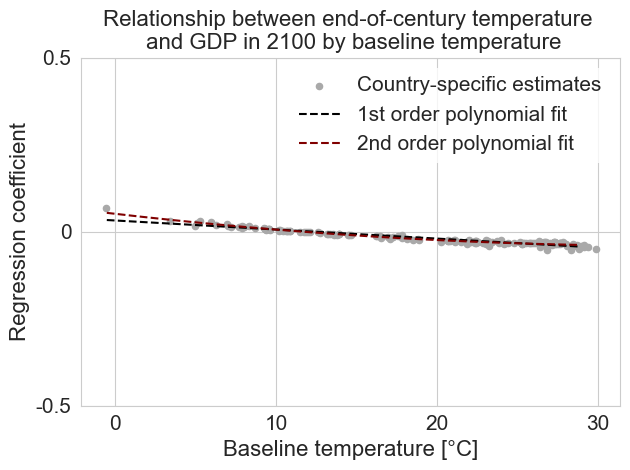

In [36]:
from sklearn.metrics import r2_score
with sns.axes_style('whitegrid'):
    plt.figure()
    for sel_predictors in [['tas_soc', 'gmt_eoc'], 
    #                       ['gmt_eoc'],
                           ]:

        coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
        
        tas_baselines    = []

        for i_iso, iso in enumerate(np.unique(regression_df['iso'])): 
            # subset data for the country 
            country_data  = regression_df[regression_df['iso'] == iso]
            y_country     = np.log(country_data['diff_SSP2'].values)
            X_country     = np.c_[ StandardScaler().fit_transform(predictor_df.loc[regression_df['iso'] == iso, sel_predictors]), 
                                np.ones(len(y_country))]

            coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
            tas_baselines.append(np.mean(country_data['tas_baseline']))

        for i_pred in range(len(sel_predictors)):
            if i_pred != 0:
                plt.scatter(tas_baselines, 
                            coefficients[:, i_pred],  
                            color = 'darkgrey',
                            s = 20,
                            label = 'Country-specific estimates')
                p = np.polyfit(tas_baselines, coefficients[:, i_pred], deg = 1)
                print(r2_score(coefficients[:, i_pred], np.polyval(p, tas_baselines)))
                plt.plot(np.arange(-0.5, 29, 0.1), np.polyval(p, np.arange(-0.5, 29, 0.1)), color = 'black', linestyle = '--', label = '1st order polynomial fit')
                p = np.polyfit(tas_baselines, coefficients[:, i_pred], deg = 2)
                print(r2_score(coefficients[:, i_pred], np.polyval(p, tas_baselines)))
                plt.plot(np.arange(-0.5, 29, 0.1), np.polyval(p, np.arange(-0.5, 29, 0.1)), color = 'maroon', linestyle = '--', label = '2nd order polynomial fit')
        plt.xticks([0,10,20,30], 
                   [0,10,20,30], 
                   fontsize = labelsize_small)
        plt.yticks([-0.5, 0, 0.5],
                  [-0.5, 0, 0.5],
                  fontsize = labelsize_small)
        plt.xlabel('Baseline temperature [°C]', fontsize = labelsize_medium)
        plt.ylabel('Regression coefficient', fontsize = labelsize_medium)
        plt.title('Relationship between end-of-century temperature \n and GDP in 2100 by baseline temperature', fontsize = labelsize_medium)
    plt.legend(fontsize = labelsize_small, facecolor = (1,1,1,0.7), edgecolor = 'none')
    plt.tight_layout()
    Path(cset.path_GRAPHICS / 'paper' / 'v0' / 'appendix').mkdir(parents=True, exist_ok=True)
    plt.savefig(cset.path_GRAPHICS / 'paper' / 'v0' / 'appendix' / 'polynomial_terms.pdf', dpi = 600)
    plt.show()

### Step 3: Fitting and evaluating different additions to base model 

a. Evaluating base model with and without additional indicators
- Defining base predictors and additional predictors
- Employing k-fold cross-validation to compare model settings 
- store results in metrics_df

In [37]:
y = np.log(regression_df['diff_SSP2'])
base_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc']

all_additional_predictors = [[],
                             ['gmt_os', 'tas_baseline gmt_os'],
                             ['gmt_ntwr', 'tas_baseline gmt_ntwr'],
                             ['gmt_exc', 'tas_baseline gmt_exc'],
                             ['gmt_max', 'tas_baseline gmt_max'],   
                             ['gmt_cum', 'tas_baseline gmt_cum']
                             ]

metrics_df = pd.DataFrame(columns = ['base'] + [f[0] for f in all_additional_predictors[1:]], 
                          index = ['R2_train', 'R2_test', 'R2_test_adjusted', 'RMSE', 'BIC']
                          )

for i, additional_predictors in enumerate(all_additional_predictors[:]): 
    if i == 0:
        sel_predictors = base_predictors.copy()
    else: 
        sel_predictors = (base_predictors + additional_predictors).copy()
        
    X = np.c_[predictor_df.loc[:, sel_predictors].values, X_intercept].copy()
    cv = KFold(n_splits=10, random_state=42, shuffle=True)

    train_r2 = []
    test_r2 = []
    bic = []
    rmse_list=[]
    
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index].copy(), X[test_index].copy(), y[train_index].copy(), y[test_index].copy()
        
        lrmodel = sm.OLS(y_train, X_train).fit()
        y_predict = lrmodel.predict(X_test)
        test_r2.append(r2_score(y_test, y_predict))
        train_r2.append(r2_score(y_train, lrmodel.fittedvalues))
        rmse_list.append(rmse(y_test, y_predict))
        bic.append(lrmodel.bic)
    adjusted_R2 = 1 - (1-np.array(test_r2))*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    metrics_df.iloc[:, i] = [np.mean(train_r2), np.mean(test_r2), np.mean(adjusted_R2), np.mean(rmse_list), np.mean(bic)]

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_35380/2413266986.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metrics_df.iloc[:, i] = [np.mean(train_r2), np.mean(test_r2), np.mean(adjusted_R2), np.mean(rmse_list), np.mean(bic)]
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_35380/2413266986.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metrics_df.iloc[:, i] = [np.mean(train_r2), np.mean(test_r2), np.mean(adjusted_R2), np.mean(rmse_list), np.mean(bic)]
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipy

In [47]:
lrmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diff_SSP2   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     3501.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:29:33   Log-Likelihood:             3.2512e+05
No. Observations:              141300   AIC:                        -6.499e+05
Df Residuals:                  141137   BIC:                        -6.483e+05
Df Model:                         162                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0431      0.000   -161.129      0.000      -0.044      -0.043
x2             0.0030   1.61e-05    186.185      0.000       0.003       0.003
x3             0.0669      0.001    108.156      0.000       0.066       0.068
x4            -0.0054   2.95e-05   -181.562      0.000      -0.005      -0.005
x5            -0.0367      0.001    -34.101      0.000      -0.039      -0.035
x6             0.0029   5.14e-05     56.333      0.000       0.003       0.003
x7            -0.0002      0.001     -0.193      0.847      -0.002       0.002
x8             0.0123      0.001     13.852      0.000       0.011       0.014
x9            -0.0006      0.001     -0.716      0.474      -0.002       0.001
x10            0.0177      0.001     18.244      0.000       0.016       0.020
x11            0.0070      0.001      7.981      0.000       0.005       0.009
x12            0.0117      0.001     12.029      0.000       0.010       0.014
x13            0.0069      0.001      7.894      0.000       0.005       0.009
x14            0.0167      0.001     16.852      0.000       0.015       0.019
x15            0.0129      0.001     13.282      0.000       0.011       0.015
x16            0.0119      0.001     13.330      0.000       0.010       0.014
x17            0.0071      0.001      7.429      0.000       0.005       0.009
x18            0.0335      0.001     35.463      0.000       0.032       0.035
x19            0.0219      0.001     22.837      0.000       0.020       0.024
x20            0.0203      0.001     22.177      0.000       0.018       0.022
x21            0.0027      0.001      2.917      0.004       0.001       0.004
x22            0.0014      0.001      1.556      0.120      -0.000       0.003
x23            0.0279      0.001     27.459      0.000       0.026       0.030
x24            0.0320      0.001     34.387      0.000       0.030       0.034
x25            0.0024      0.001      2.794      0.005       0.001       0.004
x26            0.0161      0.001     17.974      0.000       0.014       0.018
x27            0.0384      0.001     40.618      0.000       0.037       0.040
x28            0.0123      0.001     14.054      0.000       0.011       0.014
x29           -0.0038      0.001     -4.264      0.000      -0.005      -0.002
x30            0.0216      0.001     23.511      0.000       0.020       0.023
x31            0.0284      0.001     27.113      0.000       0.026       0.030
x32            0.0172      0.001     17.149      0.000       0.015       0.019
x33            0.0044      0.001      4.500      0.000       0.002       0.006
x34            0.0017      0.001      1.881      0.060   -7.07e-05       0.003
x35            0.0278      0.001     29.820      0.000       0.026       0.030
x36            0.0230      0.001     25.407      0.000       0.021       0.025
x3

b. Selecting best performing indicators based on metrics_df

In [38]:
for metric in metrics_df.index: 
    if metric in ['R2_train ', 'R2_test', 'R2_test_adjusted']:
        print(f'Best performace for {metric} :', metrics_df.columns[np.argmax(metrics_df.loc[metric, :])], np.max(metrics_df.loc[metric, :]))
    if metric in ['RMSE', 'BIC']:
        print(f'Best performace for {metric} :', metrics_df.columns[np.argmin(metrics_df.loc[metric, :])], np.min(metrics_df.loc[metric, :]))

Best performace for R2_test : gmt_cum 0.7997059096471522
Best performace for R2_test_adjusted : gmt_cum 0.799497743558196
Best performace for RMSE : gmt_cum 0.024276621372088136
Best performace for BIC : gmt_cum -648145.6844820583


In [39]:
metrics_df

,base,gmt_os,gmt_ntwr,gmt_exc,gmt_max,gmt_cum
R2_train,0.792190,0.792636,0.797352,0.795580,0.792636,0.800240
R2_test,0.791649,0.792086,0.796814,0.795039,0.792086,0.799706
R2_test_adjusted,0.791435,0.791870,0.796603,0.794826,0.791870,0.799498
RMSE,0.024761,0.024735,0.024451,0.024558,0.024735,0.024277
BIC,-642586.614346,-642866.465293,-646117.484858,-644887.290296,-642866.465293,-648145.684482


c. Training on the entire dataset and checking for significance 

In [40]:
base_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc']
sel_predictors = base_predictors.copy()
X = np.c_[predictor_df.loc[:, sel_predictors].values, X_intercept]
y = np.log(regression_df['diff_SSP2'])
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diff_SSP2   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     3736.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:12:58   Log-Likelihood:             3.5804e+05
No. Observations:              157000   AIC:                        -7.158e+05
Df Residuals:                  156839   BIC:                        -7.142e+05
Df Model:                         160                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0434      0.000   -167.609      0.000      -0.044      -0.043
x2             0.0030   1.55e-05    194.177      0.000       0.003       0.003
x3             0.0477      0.000    187.737      0.000       0.047       0.048
x4            -0.0039   1.21e-05   -317.290      0.000      -0.004      -0.004
x5             0.0017      0.001      2.144      0.032       0.000       0.003
x6             0.0333      0.001     41.457      0.000       0.032       0.035
x7             0.0031      0.001      3.887      0.000       0.002       0.005
x8             0.0508      0.001     61.551      0.000       0.049       0.052
x9             0.0169      0.001     21.068      0.000       0.015       0.018
x10            0.0053      0.001      6.403      0.000       0.004       0.007
x11            0.0149      0.001     18.512      0.000       0.013       0.016
x12            0.0086      0.001     10.360      0.000       0.007       0.010
x13            0.0058      0.001      6.924      0.000       0.004       0.007
x14            0.0316      0.001     39.375      0.000       0.030       0.033
x15            0.0034      0.001      4.077      0.000       0.002       0.005
x16            0.0650      0.001     79.280      0.000       0.063       0.067
x17            0.0557      0.001     67.296      0.000       0.054       0.057
x18            0.0478      0.001     58.700      0.000       0.046       0.049
x19            0.0029      0.001      3.524      0.000       0.001       0.004
x20            0.0026      0.001      3.231      0.001       0.001       0.004
x21            0.0178      0.001     21.205      0.000       0.016       0.019
x22            0.0606      0.001     74.299      0.000       0.059       0.062
x23            0.0181      0.001     22.640      0.000       0.017       0.020
x24            0.0393      0.001     48.785      0.000       0.038       0.041
x25            0.0692      0.001     84.463      0.000       0.068       0.071
x26            0.0315      0.001     39.297      0.000       0.030       0.033
x27            0.0165      0.001     20.587      0.000       0.015       0.018
x28            0.0492      0.001     60.630      0.000       0.048       0.051
x29            0.0150      0.001     17.564      0.000       0.013       0.017
x30            0.0076      0.001      9.084      0.000       0.006       0.009
x31           -0.0024      0.001     -2.932      0.003      -0.004      -0.001
x32            0.0055      0.001      6.863      0.000       0.004       0.007
x33            0.0576      0.001     70.528      0.000       0.056       0.059
x34            0.0497      0.001     61.306      0.000       0.048       0.051
x35            0.0424      0.001     52.570      0.000       0.041       0.044
x36            0.0463      0.001     57.222      0.000       0.045       0.048
x3

In [41]:
base_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc']
sel_predictors = base_predictors + ['gmt_exc', 'tas_baseline gmt_exc']
X = np.c_[predictor_df.loc[:, sel_predictors].values, X_intercept]
y = np.log(regression_df['diff_SSP2'])
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diff_SSP2   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3767.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:13:15   Log-Likelihood:             3.5934e+05
No. Observations:              157000   AIC:                        -7.183e+05
Df Residuals:                  156837   BIC:                        -7.167e+05
Df Model:                         162                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0433      0.000   -168.423      0.000      -0.044      -0.043
x2             0.0030   1.54e-05    195.151      0.000       0.003       0.003
x3             0.0604      0.001     99.398      0.000       0.059       0.062
x4            -0.0049    2.9e-05   -167.285      0.000      -0.005      -0.005
x5            -0.0274      0.001    -22.902      0.000      -0.030      -0.025
x6             0.0022   5.71e-05     37.917      0.000       0.002       0.002
x7             0.0028      0.001      3.270      0.001       0.001       0.004
x8             0.0443      0.001     53.293      0.000       0.043       0.046
x9             0.0051      0.001      6.088      0.000       0.003       0.007
x10            0.0678      0.001     76.673      0.000       0.066       0.069
x11            0.0221      0.001     26.796      0.000       0.020       0.024
x12            0.0021      0.001      2.318      0.020       0.000       0.004
x13            0.0189      0.001     22.800      0.000       0.017       0.020
x14            0.0045      0.001      4.945      0.000       0.003       0.006
x15            0.0022      0.001      2.464      0.014       0.000       0.004
x16            0.0418      0.001     50.539      0.000       0.040       0.043
x17            0.0015      0.001      1.670      0.095      -0.000       0.003
x18            0.0807      0.001     92.832      0.000       0.079       0.082
x19            0.0729      0.001     82.155      0.000       0.071       0.075
x20            0.0621      0.001     72.621      0.000       0.060       0.064
x21            0.0030      0.001      3.461      0.001       0.001       0.005
x22            0.0032      0.001      3.772      0.000       0.002       0.005
x23            0.0126      0.001     13.753      0.000       0.011       0.014
x24            0.0752      0.001     87.646      0.000       0.074       0.077
x25            0.0261      0.001     31.795      0.000       0.025       0.028
x26            0.0511      0.001     61.139      0.000       0.049       0.053
x27            0.0849      0.001     97.705      0.000       0.083       0.087
x28            0.0413      0.001     50.021      0.000       0.040       0.043
x29            0.0268      0.001     32.341      0.000       0.025       0.028
x30            0.0630      0.001     74.120      0.000       0.061       0.065
x31            0.0079      0.001      8.372      0.000       0.006       0.010
x32            0.0027      0.001      2.994      0.003       0.001       0.005
x33           -0.0059      0.001     -6.622      0.000      -0.008      -0.004
x34            0.0075      0.001      8.921      0.000       0.006       0.009
x35            0.0725      0.001     84.207      0.000       0.071       0.074
x36            0.0631      0.001     74.480      0.000       0.061       0.065
x3

In [42]:
base_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc']
sel_predictors = base_predictors + ['gmt_exc', 'tas_baseline gmt_exc']
X = np.c_[predictor_df.loc[:, sel_predictors].values, X_intercept]
y = np.log(regression_df['diff_SSP2'])

from sklearn.inspection import permutation_importance
model = LinearRegression().fit(X, y)
r = permutation_importance(model, X, y,
                           n_repeats=30,
                           random_state=0)

In [43]:
total = r.importances_mean.sum()
for i in r.importances_mean.argsort()[::-1]:
    if i <= 5:
    # if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(sel_predictors[i],
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}"
            f" {r.importances_mean[i]/total*100:.3f}"
        )

tas_baseline gmt_eoc 6.196 +/- 0.016 69.370
gmt_eoc 1.129 +/- 0.003 12.641
tas_soc tas_baseline 0.461 +/- 0.002 5.164
tas_soc 0.343 +/- 0.001 3.846
tas_baseline gmt_exc 0.187 +/- 0.001 2.088
gmt_exc 0.060 +/- 0.000 0.669
